In [1]:
!pip install duckdb

In [2]:
import pandas as pd
import duckdb
import os
import numpy as np
import re
import time
import psutil
import tracemalloc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define track_performance function
def track_performance(start_time, start_memory, process, records):
    elapsed_time = time.time() - start_time
    end_memory = process.memory_info().rss / (1024 * 1024)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    throughput = records / elapsed_time if elapsed_time > 0 else 0

    print(f"\n⏱️ Elapsed Time: {elapsed_time:.2f} sec")
    print(f"📊 Memory Used (Start → End): {start_memory:.2f} MB → {end_memory:.2f} MB")
    print(f"🚀 Peak Memory (tracemalloc): {peak / 1024 / 1024:.2f} MB")
    print(f"📈 Throughput: {throughput:,.2f} records/sec")
    return elapsed_time, end_memory, (peak / 1024 / 102)

In [26]:
# 1. Loads and exports a dataset using pandas while handling encoding issues

df_pandas = pd.read_csv('Dataset.csv', on_bad_lines='skip',
                        encoding='ISO-8859-1', engine='python')

df_pandas['Product Name'] = df_pandas['Product Name'].fillna('unknown'
                          ).apply(lambda x: x.encode('utf-8', 'ignore'
                          ).decode('utf-8'))

df_pandas = df_pandas[df_pandas['Product Name'].notna()]

df_pandas.to_csv('Cleaned_Dataset.csv', index=False)

In [27]:
# 1. track performance for normal cleaning process using pandas
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
mem_start = process.memory_info().rss / (1024 * 1024)

# 2. Clean Data Process (Pandas)

df_pandas = pd.read_csv("Cleaned_Dataset.csv", encoding="ISO-8859-1")
print("Original row count:", len(df))

# a. Drop duplicates
df_pandas.drop_duplicates(inplace=True)

df_copy = df_pandas.copy()

# b. Replace NaN in specific columns with "unknown"
df_copy["Product Name"] = df_copy["Product Name"].fillna("unknown")
df_copy["Location"] = df_copy["Location"].fillna("unknown")
df_copy["Price"] = df_copy["Price"].fillna("unknown")

# c.  Fill actual NaN with "0" in critical columns
df_copy["Quantity Sold"] = df_copy["Quantity Sold"].fillna("0")
df_copy["Number of Ratings"] = df_copy["Number of Ratings"].fillna("0")

# d. Clean "Quantity Sold" (e.g., "5K sold" → 5000)
import re
def clean_quantity(q):
    if isinstance(q, str):
        q = q.lower().replace("sold", "").strip()
        if "k" in q:
            return int(float(q.replace("k", "")) * 1000)
        return int(re.findall(r"\d+", q)[0]) if re.findall(r"\d+", q) else 0
    return 0

df_copy["Quantity Sold"] = df_copy["Quantity Sold"].apply(clean_quantity)

# e. Clean "Number of Ratings" (e.g., "(10)" → 10)
def clean_ratings(r):
    if isinstance(r, str):
        match = re.search(r"\d+", r)
        return int(match.group()) if match else 0
    return 0

df_copy["Number of Ratings"] = df_copy["Number of Ratings"].apply(clean_ratings)

# f. Remove non-numerical character in "Price"
df_copy["Price"] = df_copy["Price"].astype(str)

# Clean only rows that are not "unknown"
df_copy.loc[df_copy["Price"] != "unknown", "Price"] = (
    df_copy.loc[df_copy["Price"] != "unknown", "Price"]
    .str.replace(r"[^\d.]", "", regex=True)
)

# g. Convert "Price" to float and leave the word "unknown"
def to_float_or_unknown(val):
    try:
        return float(val)
    except:
        return "unknown"

df_copy["Price"] = df_copy["Price"].apply(to_float_or_unknown)


# h. Convert Quantity Sold & Number of Ratings to int
df_copy["Quantity Sold"] = df_copy["Quantity Sold"].astype(int)
df_copy["Number of Ratings"] = df_copy["Number of Ratings"].astype(int)


# Print sample result
print(df_copy.head())

df_copy.to_csv("pandas_cleaned_Lazada_dataset.csv", index=False)

# 3. record performance
elapsed_pandas, end_memory_pandas, peak_memory_pandas = track_performance(start_time, mem_start, process, df_copy.shape[0])
print(f"📄 Total Records Cleaned: {df_copy.shape[0]}")

Original row count: 120256
                                        Product Name  Price Location  \
0                [NOT FOR SALE] Korean Fashion Cloth    0.1   Penang   
1  ZD [stock] Letter Printed Short-sleeved T-shir...    0.9    China   
2  ZD Summer Yoga Beach Shorts Sports Shorts for ...    1.0    China   
3  HD Summer Yoga Beach Shorts Sports Shorts for ...    1.0    China   
4  4A Shop Running Shorts for Women Spring Summer...    1.0    China   

   Quantity Sold  Number of Ratings  
0              5                  0  
1              0                  0  
2              0                  0  
3              0                  0  
4              0                  0  

⏱️ Elapsed Time: 9.50 sec
📊 Memory Used (Start → End): 567.96 MB → 556.89 MB
🚀 Peak Memory (tracemalloc): 40.21 MB
📈 Throughput: 12,247.68 records/sec
📄 Total Records Cleaned: 116308


In [28]:
# Performance tracking
tracemalloc.start()
start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / (1024 * 1024)

# DuckDB SQL Cleaning Query
query = """
SELECT DISTINCT * FROM (
    SELECT
        CASE
            WHEN "Product Name" IS NULL OR "Product Name" = '' THEN 'unknown'
            ELSE "Product Name"
        END AS "Product Name",

        CASE
            WHEN "Location" IS NULL OR "Location" = '' THEN 'unknown'
            ELSE "Location"
        END AS "Location",

        CASE
            WHEN Price IS NULL OR TRIM(CAST(Price AS VARCHAR)) = '' THEN 'unknown'
            WHEN regexp_replace(CAST(Price AS VARCHAR), '[^0-9.]', '', 'g') = '' THEN 'unknown'
            ELSE CAST(regexp_replace(CAST(Price AS VARCHAR), '[^0-9.]', '', 'g') AS DOUBLE)
        END AS Price,

         CASE
            WHEN "Quantity Sold" IS NULL THEN 0
            WHEN LOWER("Quantity Sold") LIKE '%k%' THEN
                CAST(CAST(regexp_replace(LOWER("Quantity Sold"), '[^0-9.]', '', 'g') AS DOUBLE) * 1000 AS INT)
         ELSE
                CASE
                    WHEN regexp_extract("Quantity Sold", '\\d+') IS NULL
                        OR regexp_extract("Quantity Sold", '\\d+') = '' THEN 0
                    ELSE CAST(regexp_extract("Quantity Sold", '\\d+') AS INT)
                END
        END AS "Quantity Sold",

        CASE
            WHEN "Number of Ratings" IS NULL THEN 0
            WHEN regexp_extract("Number of Ratings", '\\d+') IS NULL
                OR regexp_extract("Number of Ratings", '\\d+') = '' THEN 0
            ELSE CAST(regexp_extract("Number of Ratings", '\\d+') AS INT)
        END AS "Number of Ratings"

    FROM read_csv_auto('Cleaned_Dataset.csv', delim=',', types={'Price': 'VARCHAR'}, ignore_errors=false)
) AS cleaned;
"""

df_duckdb = duckdb.query(query).to_df()

print(df_duckdb.head())

# Save to CSV
df_duckdb.to_csv("duckdb_cleaned_Lazada_dataset.csv", index=False)

# Record performance
elapsed_ddb, end_memory_ddb, peak_memory_ddb = track_performance(start_time, start_memory, process, df_duckdb.shape[0])
print(f"📄 Total Records Cleaned: {df_duckdb.shape[0]}")

                                        Product Name Location  Price  \
0                [NOT FOR SALE] Korean Fashion Cloth   Penang    0.1   
1  ZD Summer Yoga Beach Shorts Sports Shorts for ...    China    1.0   
2  4A Shop Running Shorts for Women Spring Summer...    China    1.0   
3  HD Breathable Sports Shorts Women's Summer Hom...    China    1.0   
4  ZD Breathable Sports Shorts Women's Summer Hom...    China    1.0   

   Quantity Sold  Number of Ratings  
0              5                  0  
1              0                  0  
2              0                  0  
3              0                  0  
4              0                  0  

⏱️ Elapsed Time: 5.04 sec
📊 Memory Used (Start → End): 556.89 MB → 543.04 MB
🚀 Peak Memory (tracemalloc): 31.86 MB
📈 Throughput: 23,060.08 records/sec
📄 Total Records Cleaned: 116296


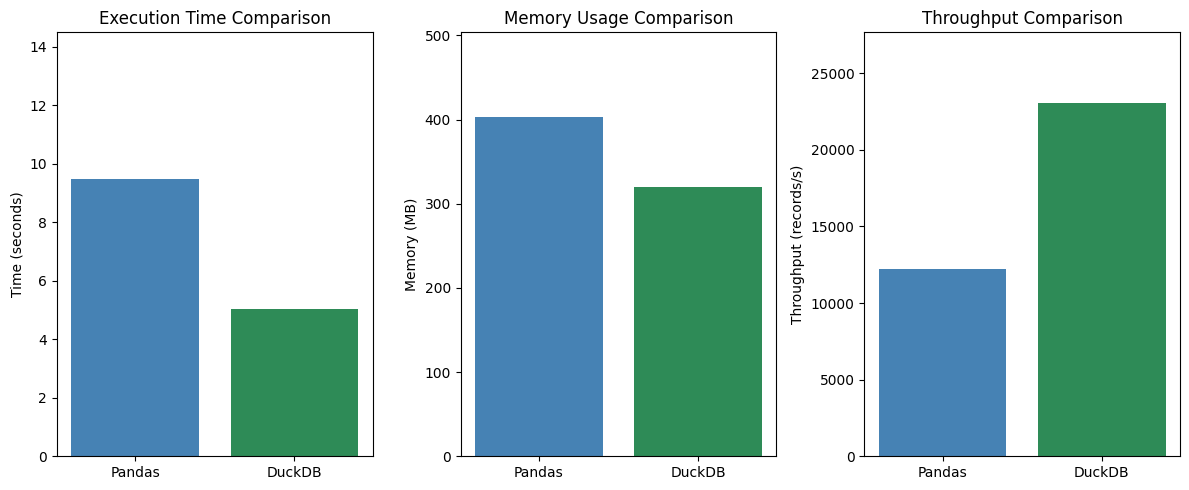

In [29]:
# Replace these with your actual measured values
data = {
    "Framework": ["Pandas", "DuckDB"],
    "Elapsed Time (s)": [elapsed_pandas, elapsed_ddb],
    "Peak Memory (MB)": [peak_memory_pandas, peak_memory_ddb],
    "Records Processed": [df_copy.shape[0], df_duckdb.shape[0]],
}

# Calculate throughput (records per second)
data["Throughput (records/s)"] = np.array(data["Records Processed"]) / np.array(data["Elapsed Time (s)"])

# Labels and values for plotting
labels = data["Framework"]
time_values = data["Elapsed Time (s)"]
memory_values = data["Peak Memory (MB)"]
throughput = data["Throughput (records/s)"]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Bar chart for time
axs[0].bar(labels, time_values, color=['steelblue', 'seagreen'])
axs[0].set_title('Execution Time Comparison')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_ylim(0, max(time_values) + 5)

# Bar chart for memory
axs[1].bar(labels, memory_values, color=['steelblue', 'seagreen'])
axs[1].set_title('Memory Usage Comparison')
axs[1].set_ylabel('Memory (MB)')
axs[1].set_ylim(0, max(memory_values) + 100)

# Bar chart for throughput
axs[2].bar(labels, throughput, color=['steelblue', 'seagreen'])
axs[2].set_title('Throughput Comparison')
axs[2].set_ylabel('Throughput (records/s)')
axs[2].set_ylim(0, max(throughput) * 1.2)

# Layout adjustment
plt.tight_layout()
plt.show()


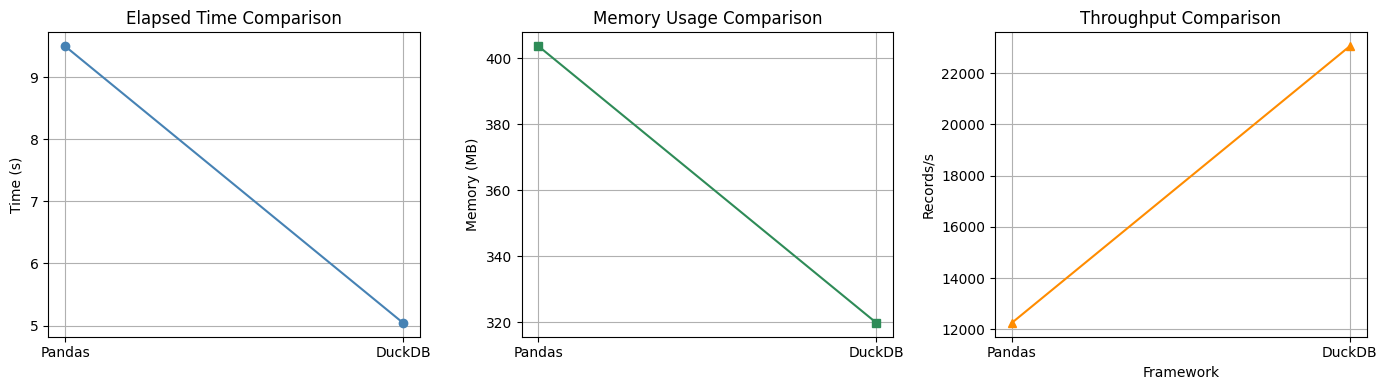

In [30]:
# X-axis
x = np.arange(len(data["Framework"]))
labels = data["Framework"]

# Set up figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Elapsed Time line chart
axs[0].plot(labels, data["Elapsed Time (s)"], marker='o', linestyle='-', color='steelblue')
axs[0].set_title('Elapsed Time Comparison')
axs[0].set_ylabel('Time (s)')
axs[0].grid(True)

# Memory Usage line chart
axs[1].plot(labels, data["Peak Memory (MB)"], marker='s', linestyle='-', color='seagreen')
axs[1].set_title('Memory Usage Comparison')
axs[1].set_ylabel('Memory (MB)')
axs[1].grid(True)

# Throughput line chart
axs[2].plot(labels, data["Throughput (records/s)"], marker='^', linestyle='-', color='darkorange')
axs[2].set_title('Throughput Comparison')
axs[2].set_ylabel('Records/s')
axs[2].grid(True)

# X-label only on the bottom plot
axs[2].set_xlabel('Framework')

# Layout adjustment
plt.tight_layout()
plt.show()